In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.neighbors
import torch

import celltrip

os.environ['AWS_PROFILE'] = 'waisman-admin'
# os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.2'
# os.environ['DISPLAY'] = ':99.0'
# os.environ['PYVISTA_OFF_SCREEN'] = 'true'
mpl.rcParams['pdf.fonttype'] = mpl.rcParams['ps.fonttype'] = 42
sns.set_theme(context='paper', style='darkgrid', palette='colorblind')


In [3]:
# Read data files
adatas = [
    celltrip.utility.processing.merge_adatas(
        *celltrip.utility.processing.read_adatas(*[
            f's3://nkalafut-celltrip/Flysta3D/{p}_{m}.h5ad'
            for p in ('E14-16h_a', 'E16-18h_a', 'L1_a', 'L2_a', 'L3_b')],
            backed=True), backed=True)
    for m in ('expression', 'spatial')]
# Model location and name (should contain .weights, .pre, and .mask file)
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Flysta3D-250729', 800
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
# Subset and preprocess the data (Use partition cols here to select data)
samples = adatas[0].obs.loc[adatas[0].obs['development'] == 'E14-16h_a'].index
samples = samples[np.random.choice(samples.shape[0], 5_000, replace=False)]  # Subsample
m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')  # pinning_modal_dims=None for lstq pinning
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [4]:
methods = ['Observed', 'CellTRIP', 'Method 1', 'Method 2']
method_colors = {'Observed': 'black', 'CellTRIP': 'blue', 'Method 1': 'green', 'Method 2': 'red'}
development = np.array(['E14-16h_a', 'E16-18h_a', 'L1_a', 'L2_a', 'L3_b'])
development_colors = {dev: c for dev, c in zip(development, sns.color_palette('husl', len(development)))}
holdout_development = np.array(['E14-16h_a', 'L2_a'])
cell_types = adatas[0].obs['annotation'].unique()
cell_type_colors = {ct: c for ct, c in zip(cell_types, sns.color_palette('colorblind', len(cell_types)))}
labels = adatas[0].obs.loc[samples, 'annotation']
points = {}
for method in methods:
    # if method == 'Observed': continue
    points[method] = {}
    for dev in development:
        points[method][dev] = {}
        if method != 'Observed':  # Testing
            points[method][dev]['obs'] = points['Observed'][dev]['obs'] + 5*np.random.rand()*(np.random.randn(*points['Observed'][dev]['obs'].shape)-.5)
            continue
        samples = adatas[0].obs.loc[adatas[0].obs['development'] == dev].index
        samples = samples[np.random.choice(samples.shape[0], 5_000, replace=False)]
        points[method][dev]['gex'] = None  # adatas[0][samples].X
        points[method][dev]['obs'] = adatas[1][samples].X
        points[method][dev]['meta'] = adatas[0].obs.loc[samples]


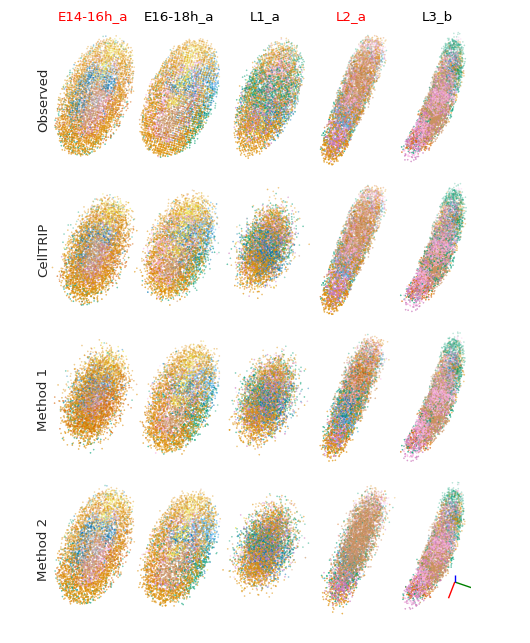

In [ ]:
# Create figure
fig, axs = plt.subplots(len(methods), len(development), subplot_kw={'projection': '3d'}, figsize=(2*len(development), 2*len(methods)))

# Data
camera_kwargs = {'elev': 70, 'azim': 20}
pca_class = {dev: sklearn.decomposition.PCA().fit(points['Observed'][dev]['obs']) for dev in development}
def transform_and_center(pca, X):
    trans_X = pca.transform(X)
    return trans_X - trans_X.mean(axis=0)
for ax, (method, dev) in zip(axs.flatten(), itertools.product(methods, development)):
    data = points[method][dev]['obs']
    data = transform_and_center(pca_class[dev], data)
    for ct in cell_types:
        # Plot
        data_filt = data[points['Observed'][dev]['meta']['annotation']==ct]
        # data_filt = data_filt[np.abs(data_filt[:, 2] - 0) < .5]  # Z-filtering
        ax.scatter(*data_filt.T, color=cell_type_colors[ct], label=ct, s=.1)
        ax.set_aspect('equal')

        # Adjust axes
        for i, axis in enumerate((ax.xaxis, ax.yaxis, ax.zaxis)):
            # Adjust ticker
            axis.set_major_locator(mpl.ticker.MultipleLocator(base=10.))
            # Remove labels
            axis.set_ticklabels([])
            # Remove small tick lines
            axis._axinfo['tick']['inward_factor'] = 0.
            axis._axinfo['tick']['outward_factor'] = 0.
            # Remove all faces and ticks
            axis.set_ticks([])
            axis.set_pane_color((1., 1., 1., 0.))
            axis.line.set_color((1., 1., 1., 0.))
        
        # Camera location
        ax.view_init(**camera_kwargs)  # YX Plane, slightly offset
        # Transparent background
        ax.set_facecolor('none')

# Super labels
for ax, method in zip(axs[:, 0], methods): ax.text2D(.2, .5, method, rotation=90, ha='center', va='center', fontsize='medium', transform=ax.transAxes)
for ax, dev in zip(axs[0], development):
    ax.text2D(.5, 1., dev, rotation=0, ha='center', va='center', color='red' if dev in holdout_development else 'black', fontsize='medium', transform=ax.transAxes)

# Orientation indicator
# ax = axs[0][0].inset_axes((.2, .75, .2, .2), projection='3d')
ax = axs[-1][-1].inset_axes((.5, .2, .2, .2), projection='3d')
ax.set_facecolor('none')
for i, axis in enumerate((ax.xaxis, ax.yaxis, ax.zaxis)):
    # Remove labels
    axis.set_ticklabels([])
    # Remove small tick lines
    axis._axinfo['tick']['inward_factor'] = 0.
    axis._axinfo['tick']['outward_factor'] = 0.
    # Remove all faces and ticks
    axis.set_ticks([])
    axis.set_pane_color((1., 1., 1., 0.))
    axis.line.set_color((1., 1., 1., 0.))
ax.grid(False)
ax.quiver(0, 0, 0, 1, 0, 0, length=.1, arrow_length_ratio=0., lw=1., color='red', zorder=1)
ax.quiver(0, 0, 0, 0, 1, 0, length=.1, arrow_length_ratio=0., lw=1., color='green', zorder=1)
ax.quiver(0, 0, 0, 0, 0, 1, length=.1, arrow_length_ratio=0., lw=1., color='blue', zorder=1)
ax.view_init(**camera_kwargs)
ax.set_aspect('equal')

# Closer together
fig.subplots_adjust(wspace=-.8, hspace=-.1)
# fig.show()
fig.savefig('../plots/flysta/prediction_visualizations.pdf', transparent=True, bbox_inches='tight')


In [6]:
# Clustering performance
classification_performance = []
for dev in development:
    # Train classifier
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=100)
    y_true = points['Observed'][dev]['meta']['annotation'].to_numpy()
    knn.fit(points['Observed'][dev]['obs'], y_true)
    for method in methods:
        # Predict on imputed data
        if method == 'Observed': continue
        pred = knn.predict(points[method][dev]['obs'])
        for ct in cell_types.tolist()+['All']:
            if ct == 'All': subset_idx = slice(None)
            else:
                subset_idx = np.argwhere(y_true==ct).flatten()
                if len(subset_idx) == 0: continue
            acc = (y_true[subset_idx] == pred[subset_idx]).mean()
            classification_performance.append({
                'Method': method, 'Development': dev, 'Cell Type': ct, 'Accuracy': acc})
classification_performance = pd.DataFrame(classification_performance)
classification_performance = classification_performance.sort_values(['Cell Type', 'Development', 'Method', 'Accuracy'], ascending=False)

/tmp/ipykernel_196332/654381827.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific['y'] = df_specific['Cell Type'].apply(lambda s: {l: float(i) for i, l in enumerate(yticklabels)}[s])


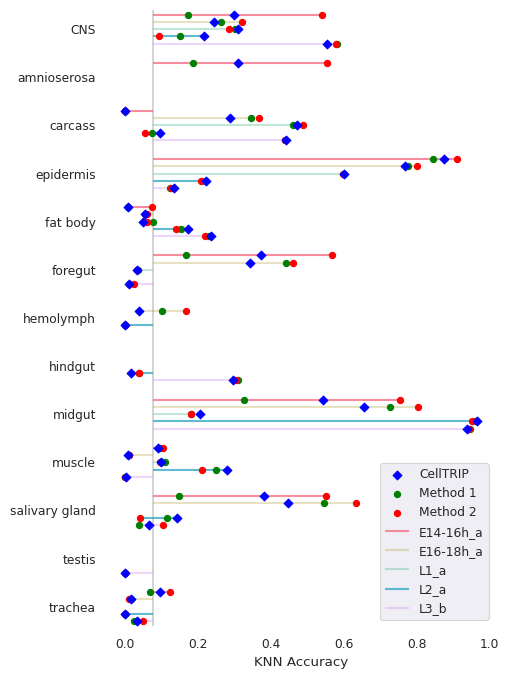

In [ ]:
# Plot
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 8))

# Prepare data
df = classification_performance.copy()
df = df.loc[df['Cell Type'].apply(lambda s: '/' not in s)]  # NOTE: Just drops these, but doesn't in the 'All' calculation
df_all = df.loc[df['Cell Type']=='All']
df_specific = df.loc[df['Cell Type']!='All']

# Set ticks
yticklabels = df_specific['Cell Type'].unique()
ax.set(
    yticks=range(len(yticklabels)),
    yticklabels=yticklabels)

# Set comparison point
midpoint = 1. / len(yticklabels)  # df_all['Accuracy'].mean()

# Apply offsets
offset = .3
development_offsets = -np.linspace(-offset, offset, len(development))
df_specific['y'] = df_specific['Cell Type'].apply(lambda s: {l: float(i) for i, l in enumerate(yticklabels)}[s])
for i, dev in enumerate(development):
    # Offset
    df_specific.loc[df_specific['Development']==dev, 'y'] += development_offsets[i]
    
# Plot by method
for method in methods:
    if method == 'Observed': continue
    df_filt = df_specific.loc[df_specific['Method']==method]
    ax.scatter(
        df_filt['Accuracy'], df_filt['y'],
        color=method_colors[method], marker='D' if method == 'CellTRIP' else 'o',
        s=20., label=method, zorder=10 if method=='CellTRIP' else 2)

# Draw lines
df_group = df_specific.groupby(['Cell Type', 'Development']).agg({'y': 'first', 'Accuracy': ['min', 'max']}).reset_index()
ax.axvline(x=midpoint, color='gray', alpha=.4, zorder=.9)
for dev in development:
    df_filt = df_group.loc[df_group['Development']==dev]
    ax.hlines(
        df_filt['y']['first'],
        # df_filt['Accuracy']['min'],
        # df_filt['Accuracy']['max'],
        np.minimum(midpoint, df_filt['Accuracy']['min']),
        np.maximum(midpoint, df_filt['Accuracy']['max']),
        color=development_colors[dev], alpha=.8 if dev in holdout_development else .3, lw=1.5, label=dev, zorder=.8)

# Format
ax.set_xlabel('KNN Accuracy')
ax.set_ylim(-offset-.1, len(yticklabels)-1+offset+.1)
sns.despine(ax=ax, left=True, bottom=True)
ax.legend()
# fig.show()
fig.savefig('../plots/flysta/prediction_classification_performance.pdf', transparent=True, bbox_inches='tight')

In [8]:
# Parameters
sequence_dev = ('L1_a', 'L2_a', 'L3_b')
initial_dev, intermediate_dev, final_dev = sequence_dev

# Get transition matrices
# Will have to transform after getting # of nodes in real
import ot
transition_matrices = []
for i in range(len(sequence_dev)-1):
    start_dev, end_dev = sequence_dev[i], sequence_dev[i+1]
    start_obs = transform_and_center(pca_class[start_dev], points['Observed'][start_dev]['obs'])
    end_obs = transform_and_center(pca_class[end_dev], points['Observed'][end_dev]['obs'])
    a, b = ot.utils.unif(start_obs.shape[0]), ot.utils.unif(end_obs.shape[0])
    M = ot.dist(start_obs, end_obs)
    M /= M.max()
    G0 = ot.emd(a, b, M, numItermax=1_000_000)
    # Gs = ot.sinkhorn(a, b, M, 1e-1)
    transition_matrices.append(G0)

# Run OT on spatial for transition matrix between states 1 and 3
# Make # of cells equal to state 3 but with state 1 gex
# Change gex and simulate, taking an intermediate point as the heldout state 2
# Compare between predicted and true
# TODO
prediction = points['CellTRIP']['L2_a']['obs'] + 3*np.random.randn(*points['CellTRIP']['L2_a']['obs'].shape)  # Testing

# Format data
spread = 50
development_offsets = -np.linspace(-spread, spread, len(sequence_dev))
meta = pd.concat([points['Observed'][dev]['meta'] for dev in sequence_dev], axis=0)
pred_mse = np.square((points['Observed'][intermediate_dev]['obs'] - prediction)).mean()
data_arr = [
    transform_and_center(pca_class[initial_dev], points['CellTRIP'][initial_dev]['obs']),
    transform_and_center(pca_class[intermediate_dev], prediction),
    transform_and_center(pca_class[final_dev], points['CellTRIP'][final_dev]['obs'])]
for i in range(len(data_arr)): data_arr[i][:, -1] += development_offsets[i]
data = np.concat(data_arr, axis=0)

In [9]:
# Arrow3D (https://stackoverflow.com/a/22867877)
class Arrow3D(mpl.patches.FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = mpl_toolkits.mplot3d.proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

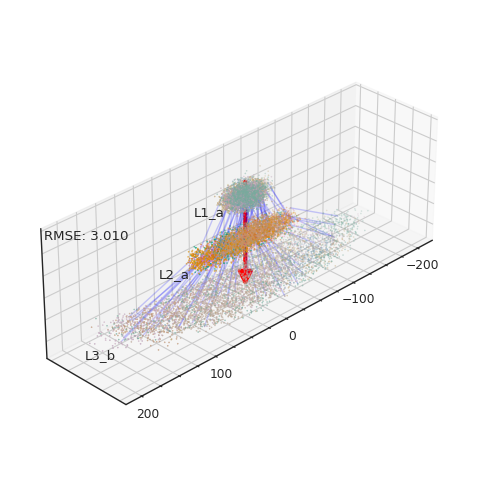

In [ ]:
fig = plt.figure(figsize=(6, 6))
with sns.axes_style('white'):
    ax = fig.add_subplot(111, projection='3d')
# Main plot
for ct, dev in itertools.product(cell_types, sequence_dev):
    color = np.array(cell_type_colors[ct])
    if dev != intermediate_dev:
        color = (1/3)*color + (2/3)*np.array(3*[.7])
    ax.scatter(
        *data[(meta['annotation']==ct)*(meta['development']==dev)].T,
        color=color,
        # alpha=.5 if dev != intermediate_dev else 1.,
        s=.1, label=ct)
# Development quivers
arrow = Arrow3D(
    (0, 0), (0, 0), (data[:, -1].max(), data[:, -1].min()),
    lw=3, mutation_scale=20, arrowstyle='-|>', color='red')
ax.add_artist(arrow)
# OT lines
num_lines = 50
for i in range(len(sequence_dev)-1):
    pairs = np.argwhere(transition_matrices[i])
    pairs = pairs[np.random.choice(pairs.shape[0], num_lines, replace=False)]
    pair_coords = np.stack([data_arr[i][pairs[:, 0]], data_arr[i+1][pairs[:, 1]]], axis=1)
    for coords in pair_coords:
        ax.plot(*coords.T, lw=1., alpha=.2, color='blue')
# Modify ticks
for i, axis in enumerate((ax.xaxis, ax.yaxis, ax.zaxis)):
    # Adjust ticker
    axis.set_major_locator(mpl.ticker.MultipleLocator(base=100.))
    axis.set_minor_locator(mpl.ticker.MultipleLocator(base=25.))
    if i != 0:
        # Remove labels
        axis.set_ticklabels([])
        # Remove small tick lines
        axis._axinfo['tick']['inward_factor'] = 0.
        axis._axinfo['tick']['outward_factor'] = 0.
# Annotations
ax.text3D(50, 0, development_offsets[0], initial_dev, ha='center', va='center', fontsize='medium', zorder=50)
ax.text3D(100, 0, development_offsets[1], intermediate_dev, ha='center', va='center', fontsize='medium', zorder=50)
ax.text3D(200, 0, development_offsets[2], final_dev, ha='center', va='center', fontsize='medium', zorder=50)
ax.text3D(ax.get_xlim()[1]-2, ax.get_ylim()[0]+2, ax.get_zlim()[1]-2, f'RMSE: {np.sqrt(pred_mse):.3f}', ha='left', va='top', fontsize='medium', zorder=50)
# Formatting
ax.view_init(elev=30, azim=45)
ax.set_aspect('equal')
# fig.show()
fig.savefig('../plots/flysta/interpolation_visualization.pdf', transparent=True, bbox_inches='tight')

In [11]:
# Perform knockdown on particular stage
# Measure significance of knockdown for each cell type
# TODO
knockdown_significance = []
for gene, ct in itertools.product(adatas[0].var.index, cell_types):
    significance = np.random.rand()**6  # Testing
    trend = .05*np.random.randn()  # Testing
    noise = .3*np.random.randn()  # Testing
    for i, dev in enumerate(development):
        dev_sig = np.clip(significance + i*trend + noise*np.random.randn(), 0, 1)  # Testing
        knockdown_significance.append({
            'Gene': gene,
            'Cell Type': ct,
            'Development': dev,
            'Effect': dev_sig})
knockdown_significance = pd.DataFrame(knockdown_significance)


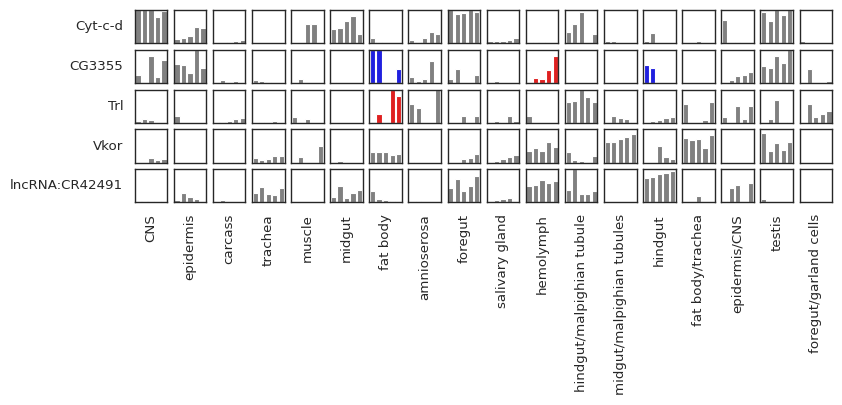

In [ ]:
# Create figure
num_genes = 5
fig = plt.figure(figsize=(.5*len(cell_types), .5*num_genes))
with sns.axes_style('white'):
    axs = fig.subplots(num_genes, len(cell_types), sharex=True, sharey=True)

# Select and plot genes
genes = np.random.choice(adatas[0].var.index, num_genes, replace=False)
for axs_gene, gene in zip(axs, genes):
    for ax, ct in zip(axs_gene, cell_types):
        # Filter data
        df_filt = knockdown_significance.loc[(knockdown_significance['Gene']==gene)*(knockdown_significance['Cell Type']==ct)]
        x = df_filt['Development'].apply(lambda s: {l: float(i) for i, l in enumerate(development)}[s])
        y = df_filt['Effect']

        # Identify trend
        m, b = np.polyfit(x, y, 1)
        threshold = .15
        if m > threshold: color = 'red'
        elif m < -threshold: color = 'blue'
        else: color = 'gray'

        # Barplot
        sns.barplot(df_filt, x='Development', y='Effect', color=color, ax=ax)

        # Style
        ax.set_xlabel(ct, rotation=90, labelpad=0, ha='center', va='top')
        ax.set_ylabel(gene, rotation=0, labelpad=0, ha='right', va='center')
        ax.set(xticklabels=[], yticklabels=[])
        # ax.set_aspect('equal', 'box')
        ax.set_ylim(0, 1)

# fig.show()
fig.savefig('../plots/flysta/perturbation_effects.pdf', transparent=True, bbox_inches='tight')